In [1]:
import pathlib
from importlib import reload
import numpy as np
import torch
import matplotlib.pyplot as plt

import lab3
reload(lab3)

import lab3.classes
reload(lab3.classes)
import lab3.classes as cs

import lab3.show
reload(lab3.show)
from lab3.show import display_img_with_masks, display_masks

import lab3.trans
reload(lab3.trans)
from lab3.trans import validation_trans, train_trans, test_trans

import lab3.dataset
reload(lab3.dataset)
from lab3.dataset import FiftyOneDataset

import lab3.net
reload(lab3.net)
from lab3.net import Net

import lab1.device
reload(lab1.device)
from lab1.device import device

import lab3.util
reload(lab3.util)
from lab3.util import seconds_to_time

device

device(type='mps')

In [2]:
import os
from typing import Literal
import fiftyone as fo
import fiftyone.utils.openimages as fouo
import fiftyone.zoo as foz
import cv2

def download(split = "train", max_samples: int = 2000):
  return foz.load_zoo_dataset(
    "open-images-v6",
    split        = split,
    label_types  = ["segmentations", "detections"],
    classes      = cs.classes_no_background,
    max_samples  = max_samples,
    dataset_dir  = "data-lab3",
    dataset_name =f"open-images-v6-{split}"
  )

def load(split = "train"):
  dataset =  fouo.OpenImagesV6DatasetImporter(
    dataset_dir = f"data-lab3/{split}",
    label_types = "segmentations"
  )

  dataset.setup()

  return dataset

def resize_dataset(path):
  for p in os.listdir(path):
    image = cv2.imread(path + p, cv2.IMREAD_UNCHANGED)
    print(image)
    
    if image.shape[1] > image.shape[0]:
      scale = 128 / image.shape[0]
    else:
      scale = 128 / image.shape[1]
    
    width = int(image.shape[1] * scale)
    height = int(image.shape[0] * scale)
    dim = (width, height)
    
    # resize image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_NEAREST)
    
    print('Resized Dimensions : ',resized.shape)

RESIZE = False
if RESIZE:
  resize_dataset('./data-lab3/test/data/')
  resize_dataset('./data-lab3/validation/data/')
  resize_dataset('./data-lab3/train/data/')
# train_ds = download("train")
# valid_ds = download("validation", max_samples = 300)
# test_ds  = download("test", max_samples = 300)

train_ds = load("train")
valid_ds = load("validation")

train_ds #, fo.list_datasets()

In [3]:
import torch
import torch.utils.data as tud

train_dataset = FiftyOneDataset(train_ds, train_trans)
valid_dataset = FiftyOneDataset(valid_ds, validation_trans)

num_workers = 8
batch_size = 128

train_ld = tud.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
valid_ld = tud.DataLoader(valid_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

print(f'Train: {len(train_dataset)}, Test: {len(valid_dataset)}')

Train: 808, Test: 157


In [4]:
from statistics import mean
from sklearn.metrics import f1_score
from torch import tensor as t, concat as c

ZERO = torch.zeros(0, 6, 128, 128) < 1

class Stats:
  length = 0
  
  dice: float = 0
  iou:  float  = 0
  f1_micro: float = 0
  f1_macro: float = 0
  
  loss_acum: list[float] = []
  
  def init(self):
    pass
  
  def add_data(self, ys: torch.Tensor, y_hats: torch.Tensor, loss: float):
    # print(f"TYPE: {type(ys)}")
    # print(f"LEN:  {ys}")
    self.length += ys.shape[0]
    self.loss_acum.append(loss)

    intersection = torch.bitwise_and(ys, y_hats)
    union = torch.bitwise_or(ys, y_hats)

    intersection = torch.sum(intersection)
    union = torch.sum(union)

    # Jaccard = || A \intersect B || / || A \union B ||
    iou = intersection / union

    # DICE = 2 || A \intersect B || / (||A|| + ||B||)
    dice = 2 * intersection / (torch.sum(ys) + torch.sum(y_hats))

    # Flatten the tensors
    ys_flat = ys.view(-1).numpy()
    y_hats_flat = y_hats.view(-1).numpy()

    # Calculate Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(ys_flat, y_hats_flat, average='micro')
    macro_f1 = f1_score(ys_flat, y_hats_flat, average='macro')
    
    self.iou  += iou.item()
    self.dice += dice.item()
    self.f1_macro += macro_f1.item()
    self.f1_micro += micro_f1.item()
  
  def get_stats(self):
    return (
      self.iou / self.length, 
      self.dice / self.length,
      self.f1_micro / self.length,
      self.f1_macro / self.length,
      mean(self.loss_acum)
    )

def run_epoch(model: Net,
              loader: torch.utils.data.DataLoader,
              loss_fn, optimizer):
  stats = Stats()
  IS_TRAIN = optimizer is not None
  
  if IS_TRAIN:
    model.train()
  else:
    model.eval()

  ix = -1
  for images, true_masks in loader:
    images = images.to(device)
    true_masks = true_masks.to(device)
    
    if not IS_TRAIN:
      with torch.no_grad():
        predictions = model(images)
    else:
      predictions = model(images)
      

    loss = loss_fn(true_masks, predictions)

    # print(f"  PRED_MAX: {predictions.max()}")
    predictions = predictions > 0.5
    true_masks = true_masks > 0.5
    stats.add_data(true_masks.cpu().detach(), predictions.cpu().detach(), loss.cpu().detach().item())
    
    if IS_TRAIN:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    if ix == 0:
      break
    ix -= 1
  
  ret = stats.get_stats()
  return ret


In [5]:
from datetime import datetime

def train_and_eval(model, train_ld, valid_ld, epoch_count = 10, learning_rate = 1e-3):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  start_time = datetime.now()

  train_loss_acum  = []
  train_iou_acum   = []
  train_dice_acum  = []
  train_micro_acum = []
  train_macro_acum = []
  valid_loss_acum  = []
  valid_iou_acum   = []
  valid_dice_acum  = []
  valid_micro_acum = []
  valid_macro_acum = []
  
  for epoch in range(epoch_count):
    print(f'EPOCH: {epoch + 1} / {epoch_count}')
    train_iou, train_dice, train_micro, train_macro, train_loss = run_epoch(model, train_ld, loss_func, optimizer)
    
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'  train      | Elapsed: {elapsed}')

    valid_iou, valid_dice, valid_micro, valid_macro, valid_loss = run_epoch(model, valid_ld, loss_func, optimizer)
    
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'  valid      | Elapsed: {elapsed}')

    train_iou_acum.append(train_iou)
    train_dice_acum.append(train_dice)
    train_micro_acum.append(train_micro)
    train_macro_acum.append(train_macro)
    train_loss_acum.append(train_loss)
    
    valid_iou_acum.append(valid_iou)
    valid_dice_acum.append(valid_dice)
    valid_micro_acum.append(valid_micro)
    valid_macro_acum.append(valid_macro)
    valid_loss_acum.append(valid_loss)

    print(f'  Training Loss:  {train_loss},  Validation Loss:  {valid_loss}')
    print(f'  Training IoU:   {train_iou},   Validation IoU:   {valid_iou}')
    print(f'  Training Dice:  {train_dice},  Validation Dice:  {valid_dice}')
    print(f'  Training Micro: {train_micro}, Validation Micro: {valid_micro}')
    print(f'  Training Macro: {train_macro}, Validation Macro: {valid_macro}')

  return train_iou_acum, valid_iou_acum, train_dice_acum, valid_dice_acum, train_micro_acum, valid_micro_acum, train_macro_acum, valid_macro_acum, train_loss_acum, valid_loss_acum

In [6]:
def plot(train, valid, label = "IoU"):
  plt.clf()
  plt.plot(train, 'b', label = f'Training {label}')
  plt.plot(valid, 'r', label = f'Validation {label}')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

In [7]:
# train_dataset[0]
# np.zeros(4).reshape((2, 2)).shape

In [8]:
model = Net(train_dataset[0][0].shape[0], num_classes = cs.num_classes).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

EPOCHS = 100

train_iou, valid_iou, train_dice, valid_dice, train_micro, valid_micro, train_macro, valid_macro, train_loss, valid_loss = train_and_eval(model, train_ld, valid_ld, epoch_count = EPOCHS, learning_rate = 1e-3)


Parameter count: 1,928,582
EPOCH: 1 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9480430483818054


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.8741291165351868


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.925017774105072


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9125930070877075


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9307500123977661


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9255238175392151


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.968255341053009
  train      | Elapsed: 1m15s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9330665469169617


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9041039347648621
  valid      | Elapsed: 1m57s
  Training Loss:  1.8137191534042358,  Validation Loss:  1.8009554147720337
  Training IoU:   0.0001386535974179964,   Validation IoU:   0.0026015353620431987
  Training Dice:  0.000265787295773245,  Validation Dice:  0.004302384177590632
  Training Micro: 0.00722529711109577, Validation Micro: 0.010936068043246941
  Training Macro: 0.004071357369912413, Validation Macro: 0.008015924704542142
EPOCH: 2 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.987293004989624


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9895319938659668


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9819815754890442


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.97077876329422


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9841731786727905


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9975540041923523


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9923359751701355
  train      | Elapsed: 3m21s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9880956411361694


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9820526242256165
  valid      | Elapsed: 4m4s
  Training Loss:  1.7646073997020721,  Validation Loss:  1.7563477555910747
  Training IoU:   0.0024761240560524536,   Validation IoU:   0.004023899508130019
  Training Dice:  0.003845584090098296,  Validation Dice:  0.006114681245415074
  Training Micro: 0.007557282491092241, Validation Micro: 0.011158798054952696
  Training Macro: 0.005942073030926035, Validation Macro: 0.008978258163219136
EPOCH: 3 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.99415522813797


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9971338510513306


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9967646598815918


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.998748779296875


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9969176054000854


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9991408586502075


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9983798265457153
  train      | Elapsed: 5m18s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9946681261062622


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9949119687080383
  valid      | Elapsed: 6m4s
  Training Loss:  1.729653286933899,  Validation Loss:  1.7233011060290866
  Training IoU:   0.003135704131114601,   Validation IoU:   0.004676461029963888
  Training Dice:  0.00460317192396315,  Validation Dice:  0.006839451516509816
  Training Micro: 0.00767085080099578, Validation Micro: 0.011278482820167489
  Training Macro: 0.006350585952088131, Validation Macro: 0.009372486218382515
EPOCH: 4 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9997523427009583


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9993419051170349


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999921441078186


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9990608096122742


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998661279678345


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9994148015975952


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9977211356163025
  train      | Elapsed: 7m21s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9988290667533875


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.997918426990509
  valid      | Elapsed: 8m3s
  Training Loss:  1.7012721159878899,  Validation Loss:  1.695706672138638
  Training IoU:   0.0036420916566754333,   Validation IoU:   0.005332996511155633
  Training Dice:  0.0051260330151803426,  Validation Dice:  0.007516045479258155
  Training Micro: 0.007756567630830771, Validation Micro: 0.011381905392555255
  Training Macro: 0.006634667531322449, Validation Macro: 0.00973756352014276
EPOCH: 5 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.999805748462677


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999704360961914


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9996004700660706


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998356103897095


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998975992202759


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999793767929077


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9997807145118713
  train      | Elapsed: 9m19s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9996887445449829


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9990478157997131
  valid      | Elapsed: 10m2s
  Training Loss:  1.6770464514577113,  Validation Loss:  1.6721907244788277
  Training IoU:   0.0039531168076071405,   Validation IoU:   0.00570637082598012
  Training Dice:  0.00542718120435677,  Validation Dice:  0.007881160374659642
  Training Micro: 0.007801107034431433, Validation Micro: 0.011437412952205536
  Training Macro: 0.006796575068865506, Validation Macro: 0.00993431969735997
EPOCH: 6 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999576807022095


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999737739562988


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.99997878074646


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999938011169434


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999905824661255


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999953508377075


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999996423721313
  train      | Elapsed: 11m21s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999700784683228


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998974800109863
  valid      | Elapsed: 12m4s
  Training Loss:  1.6544728370813222,  Validation Loss:  1.6499987575742934
  Training IoU:   0.00432039738291561,   Validation IoU:   0.00608924183116597
  Training Dice:  0.005765195825312397,  Validation Dice:  0.008238363038202759
  Training Micro: 0.007868265928608356, Validation Micro: 0.011505567431406252
  Training Macro: 0.006983903405541412, Validation Macro: 0.010131331775310982
EPOCH: 7 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9998900890350342


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999922513961792


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999849796295166


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999996542930603


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999912977218628


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998834133148193


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999421834945679
  train      | Elapsed: 13m19s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9995026588439941


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9992972612380981
  valid      | Elapsed: 14m2s
  Training Loss:  1.6339817183916685,  Validation Loss:  1.6297623732733348
  Training IoU:   0.004493212862180011,   Validation IoU:   0.006714006897750174
  Training Dice:  0.005914989674445426,  Validation Dice:  0.008791149042214558
  Training Micro: 0.00788979430009823, Validation Micro: 0.011606177348798728
  Training Macro: 0.0070641088684924936, Validation Macro: 0.010434398554314508
EPOCH: 8 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9998464584350586


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999620914459229


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999812841415405


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999829530715942


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999826967716217


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999736547470093


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999861717224121
  train      | Elapsed: 15m18s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999990463256836


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999995231628418
  valid      | Elapsed: 16m0s
  Training Loss:  1.6145811591829573,  Validation Loss:  1.6109150681230757
  Training IoU:   0.004758207514734551,   Validation IoU:   0.006555331930233415
  Training Dice:  0.006142370181508584,  Validation Dice:  0.008647756591723984
  Training Micro: 0.007934422009062058, Validation Micro: 0.011581785639240554
  Training Macro: 0.007189830554878492, Validation Macro: 0.010356392810367586
EPOCH: 9 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999982118606567


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998639822006226


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998695850372314


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998018145561218


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999696016311646


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999505281448364


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999576807022095
  train      | Elapsed: 17m13s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999089241027832


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999217987060547
  valid      | Elapsed: 17m55s
  Training Loss:  1.596178616149516,  Validation Loss:  1.592613407123236
  Training IoU:   0.004986306375796252,   Validation IoU:   0.006931005389827072
  Training Dice:  0.006328807166307279,  Validation Dice:  0.008971133429533358
  Training Micro: 0.007979457704934351, Validation Micro: 0.011642901577479286
  Training Macro: 0.007295767394346252, Validation Macro: 0.010534374894859255
EPOCH: 10 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999947547912598


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999991655349731


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999969005584717


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999958276748657


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999986886978149


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999934434890747
  train      | Elapsed: 19m8s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999987006187439


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999735355377197
  valid      | Elapsed: 19m50s
  Training Loss:  1.5793041329492221,  Validation Loss:  1.5759761373202006
  Training IoU:   0.005086243890299655,   Validation IoU:   0.007195119265538112
  Training Dice:  0.006408553017248022,  Validation Dice:  0.009192717303136352
  Training Micro: 0.008000841490899769, Validation Micro: 0.01169226206067244
  Training Macro: 0.0073417994631723785, Validation Macro: 0.010658841482080735
EPOCH: 11 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999997615814209


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999992847442627


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999980926513672


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999934434890747


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999998927116394


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999951124191284
  train      | Elapsed: 21m7s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999909400939941


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999806880950928
  valid      | Elapsed: 21m49s
  Training Loss:  1.5632856445214183,  Validation Loss:  1.560208751697733
  Training IoU:   0.00526367046750418,   Validation IoU:   0.00738155689968425
  Training Dice:  0.006548209281841127,  Validation Dice:  0.009342139693582134
  Training Micro: 0.008030015053135334, Validation Micro: 0.01171725246111901
  Training Macro: 0.007419569129510904, Validation Macro: 0.010739889968023462
EPOCH: 12 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999915361404419


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999988079071045


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999969005584717


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999995231628418
  train      | Elapsed: 23m1s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999972581863403


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999899864196777
  valid      | Elapsed: 23m43s
  Training Loss:  1.5483132387107272,  Validation Loss:  1.5454533022862893
  Training IoU:   0.005326767295303911,   Validation IoU:   0.007504399415034398
  Training Dice:  0.00659607203290014,  Validation Dice:  0.00943409561351606
  Training Micro: 0.0080411691083373, Validation Micro: 0.011741834378397842
  Training Macro: 0.007446610931014385, Validation Macro: 0.010792940815740467
EPOCH: 13 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999994039535522


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999991655349731


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999998927116394


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999998927116394


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999982118606567
  train      | Elapsed: 24m58s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999988317489624


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9998936653137207
  valid      | Elapsed: 25m41s
  Training Loss:  1.5339125498481418,  Validation Loss:  1.531210734294011
  Training IoU:   0.005492366776608005,   Validation IoU:   0.007745638015163932
  Training Dice:  0.0067218176946781645,  Validation Dice:  0.009624650523920728
  Training Micro: 0.00807536561103544, Validation Micro: 0.0117868556923255
  Training Macro: 0.0075193593197089535, Validation Macro: 0.01090081127732109
EPOCH: 14 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999996423721313


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999943971633911


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999997615814209


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 26m56s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999995231628418


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999994158744812
  valid      | Elapsed: 27m39s
  Training Loss:  1.5204504093816202,  Validation Loss:  1.517907132232
  Training IoU:   0.005551756977444828,   Validation IoU:   0.007778867414802502
  Training Dice:  0.006765625485689333,  Validation Dice:  0.009648100585694526
  Training Micro: 0.00808349338301731, Validation Micro: 0.011793004601563269
  Training Macro: 0.007543384847815998, Validation Macro: 0.010914296609573285
EPOCH: 15 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999997615814209


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999992847442627


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999996423721313


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999996423721313
  train      | Elapsed: 28m51s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999984502792358
  valid      | Elapsed: 29m33s
  Training Loss:  1.5072974540237198,  Validation Loss:  1.504894099412141
  Training IoU:   0.0057747570594938675,   Validation IoU:   0.007933031221863571
  Training Dice:  0.006928931073387071,  Validation Dice:  0.009757984216046182
  Training Micro: 0.008128694889962478, Validation Micro: 0.01182141806023459
  Training Macro: 0.007638123162582463, Validation Macro: 0.01097734227262797
EPOCH: 16 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999966621398926


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999986886978149


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999992847442627


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999995231628418


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999984502792358
  train      | Elapsed: 30m50s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999986886978149


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999786615371704
  valid      | Elapsed: 31m32s
  Training Loss:  1.4949750321012147,  Validation Loss:  1.4926308054063055
  Training IoU:   0.005734889150255978,   Validation IoU:   0.008210298741699025
  Training Dice:  0.006899715576431539,  Validation Dice:  0.00996477133149554
  Training Micro: 0.00811611229043589, Validation Micro: 0.011866173411508335
  Training Macro: 0.007619600906024191, Validation Macro: 0.011092920763789293
EPOCH: 17 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999982118606567


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999964237213135


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999978542327881


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999983310699463


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999971389770508
  train      | Elapsed: 32m44s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999909400939941


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999562501907349
  valid      | Elapsed: 33m26s
  Training Loss:  1.483110914956655,  Validation Loss:  1.4810101611941469
  Training IoU:   0.006094195022441373,   Validation IoU:   0.008179440619839225
  Training Dice:  0.0071527081550938065,  Validation Dice:  0.009944631035920162
  Training Micro: 0.008175691932734876, Validation Micro: 0.011817429178987645
  Training Macro: 0.007762628747165747, Validation Macro: 0.011065906253621204
EPOCH: 18 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999992847442627


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 34m38s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.999997615814209
  valid      | Elapsed: 35m21s
  Training Loss:  1.4717393875122071,  Validation Loss:  1.4697158373432395
  Training IoU:   0.006344742261537231,   Validation IoU:   0.008326656119838642
  Training Dice:  0.007324140777092169,  Validation Dice:  0.01004762292667559
  Training Micro: 0.00822119927248939, Validation Micro: 0.01184605799811207
  Training Macro: 0.00786135488756372, Validation Macro: 0.01112565500490866
EPOCH: 19 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 0.9999984502792358


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104
  train      | Elapsed: 36m34s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999996423721313
  valid      | Elapsed: 37m15s
  Training Loss:  1.4609727041255793,  Validation Loss:  1.4591176063693754
  Training IoU:   0.0063271696614747,   Validation IoU:   0.00830315670390038
  Training Dice:  0.00731280394414864,  Validation Dice:  0.010030171673768644
  Training Micro: 0.008215257672980281, Validation Micro: 0.011838736563094041
  Training Macro: 0.007853776455048148, Validation Macro: 0.011114643440290624
EPOCH: 20 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 38m29s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999997615814209
  valid      | Elapsed: 39m11s
  Training Loss:  1.450947501686182,  Validation Loss:  1.44917350742552
  Training IoU:   0.006341401081864197,   Validation IoU:   0.008373723667897995
  Training Dice:  0.007319789785559814,  Validation Dice:  0.01007960366595323
  Training Micro: 0.008216815223001411, Validation Micro: 0.011853916734594475
  Training Macro: 0.007857690884946783, Validation Macro: 0.01114383617617603
EPOCH: 21 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999996423721313


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999997615814209


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999995231628418


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999994039535522
  train      | Elapsed: 40m28s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999997615814209
  valid      | Elapsed: 41m10s
  Training Loss:  1.441318488376026,  Validation Loss:  1.4396995602461395
  Training IoU:   0.006361727814863224,   Validation IoU:   0.008311972496615853
  Training Dice:  0.0073358336887737316,  Validation Dice:  0.01004057629093243
  Training Micro: 0.008222063382466635, Validation Micro: 0.011841035533312675
  Training Macro: 0.007867281315314337, Validation Macro: 0.01112046580312361
EPOCH: 22 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 42m22s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 43m3s
  Training Loss:  1.4323129045720002,  Validation Loss:  1.4308200839794043
  Training IoU:   0.0064097891497139885,   Validation IoU:   0.00831798763032172
  Training Dice:  0.007366259204279078,  Validation Dice:  0.010043157513733882
  Training Micro: 0.008231778074019026, Validation Micro: 0.01184136845355275
  Training Macro: 0.007885383054306649, Validation Macro: 0.011121824800496961
EPOCH: 23 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 44m16s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 44m57s
  Training Loss:  1.4237986064538724,  Validation Loss:  1.4224010965098506
  Training IoU:   0.006436351207223269,   Validation IoU:   0.008330718347221423
  Training Dice:  0.007384052592338902,  Validation Dice:  0.010050337026073674
  Training Micro: 0.008237507477058436, Validation Micro: 0.011843847280645173
  Training Macro: 0.007895986446990053, Validation Macro: 0.011126163219201545
EPOCH: 24 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 46m16s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999996423721313
  valid      | Elapsed: 46m59s
  Training Loss:  1.4158545442830737,  Validation Loss:  1.4145142789240237
  Training IoU:   0.0064110714610260315,   Validation IoU:   0.008431849965623989
  Training Dice:  0.00736833791626562,  Validation Dice:  0.010123622265590984
  Training Micro: 0.008232293605017583, Validation Micro: 0.011867761559573316
  Training Macro: 0.00788656644225557, Validation Macro: 0.011169949471472868
EPOCH: 25 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 48m11s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104
  valid      | Elapsed: 48m53s
  Training Loss:  1.408432219595118,  Validation Loss:  1.4072351174884372
  Training IoU:   0.006395440806846808,   Validation IoU:   0.008329038027745143
  Training Dice:  0.007358040992576297,  Validation Dice:  0.010052499118124603
  Training Micro: 0.008228640863210849, Validation Micro: 0.011844128272100357
  Training Macro: 0.007880308945802737, Validation Macro: 0.011127302382271376
EPOCH: 26 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 50m5s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 50m47s
  Training Loss:  1.4015076869520648,  Validation Loss:  1.400387479708745
  Training IoU:   0.006402319832013385,   Validation IoU:   0.008365434446152608
  Training Dice:  0.007362725858641143,  Validation Dice:  0.01007752092021286
  Training Micro: 0.008230206773619447, Validation Micro: 0.011852213627545531
  Training Macro: 0.007883121410041752, Validation Macro: 0.011142223487142318
EPOCH: 27 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 51m59s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 52m41s
  Training Loss:  1.3950173102968462,  Validation Loss:  1.3939873215592937
  Training IoU:   0.006381499664028093,   Validation IoU:   0.008348199971921884
  Training Dice:  0.007348532059995255,  Validation Dice:  0.010061763654089277
  Training Micro: 0.008225431457997942, Validation Micro: 0.011846953355093915
  Training Macro: 0.00787458929167556, Validation Macro: 0.011132766364513958
EPOCH: 28 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 53m54s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 54m35s
  Training Loss:  1.388841926574707,  Validation Loss:  1.3878957449443756
  Training IoU:   0.006428420617438779,   Validation IoU:   0.008322412041342183
  Training Dice:  0.0073789909924611005,  Validation Dice:  0.010048840455948168
  Training Micro: 0.00823553729765486, Validation Micro: 0.011842421883501309
  Training Macro: 0.007892847691829755, Validation Macro: 0.011124931851129076
EPOCH: 29 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 55m49s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 56m36s
  Training Loss:  1.3830622071004743,  Validation Loss:  1.3821497968330236
  Training IoU:   0.006416590939653982,   Validation IoU:   0.008387674951249627
  Training Dice:  0.007371984938583751,  Validation Dice:  0.010092308187181024
  Training Micro: 0.00823317829138375, Validation Micro: 0.01185727671025499
  Training Macro: 0.007888635551598218, Validation Macro: 0.011151143941957648
EPOCH: 30 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 57m49s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 58m31s
  Training Loss:  1.3775060781792028,  Validation Loss:  1.376637182412324
  Training IoU:   0.006454991969731774,   Validation IoU:   0.008433819576433509
  Training Dice:  0.00739650826643009,  Validation Dice:  0.010125695520145878
  Training Micro: 0.008241315249956088, Validation Micro: 0.011868291477549957
  Training Macro: 0.007903336047754693, Validation Macro: 0.011171135276719616
EPOCH: 31 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 59m46s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h0m29s
  Training Loss:  1.372328170370109,  Validation Loss:  1.37153441589793
  Training IoU:   0.006412133353181405,   Validation IoU:   0.008390300592799096
  Training Dice:  0.0073690946296890185,  Validation Dice:  0.010096833204767506
  Training Micro: 0.008232160704364083, Validation Micro: 0.011858447246159124
  Training Macro: 0.007886881853968034, Validation Macro: 0.01115373752376546
EPOCH: 32 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h1m42s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h2m24s
  Training Loss:  1.3673839364852105,  Validation Loss:  1.3666672892868519
  Training IoU:   0.006456204348861581,   Validation IoU:   0.008341947558579171
  Training Dice:  0.0073980265619731185,  Validation Dice:  0.010060753412307447
  Training Micro: 0.008241817797764693, Validation Micro: 0.011846419160629106
  Training Macro: 0.007904245751572671, Validation Macro: 0.01113208912316318
EPOCH: 33 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h3m37s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999997615814209
  valid      | Elapsed: 1h4m20s
  Training Loss:  1.3628135301299014,  Validation Loss:  1.3621314157941928
  Training IoU:   0.006416047342342905,   Validation IoU:   0.008360178607284644
  Training Dice:  0.0073700783276321865,  Validation Dice:  0.010076446897664647
  Training Micro: 0.008232429397381572, Validation Micro: 0.01185168627546179
  Training Macro: 0.007887450825492855, Validation Macro: 0.01114151817063127
EPOCH: 34 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h5m36s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h6m18s
  Training Loss:  1.3584730025184781,  Validation Loss:  1.3578441929973029
  Training IoU:   0.006413593371905903,   Validation IoU:   0.008334750962105526
  Training Dice:  0.007369978076750689,  Validation Dice:  0.010055562113500704
  Training Micro: 0.008232377621993766, Validation Micro: 0.011844610380684791
  Training Macro: 0.007887384011373727, Validation Macro: 0.011128946163677354
EPOCH: 35 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h7m32s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h8m15s
  Training Loss:  1.3543878283363562,  Validation Loss:  1.3537694639629787
  Training IoU:   0.0064004242125124036,   Validation IoU:   0.008418138999088555
  Training Dice:  0.007360345435024488,  Validation Dice:  0.010114364183632431
  Training Micro: 0.008229143332333454, Validation Micro: 0.011864255816758975
  Training Macro: 0.007881596050346065, Validation Macro: 0.011164243505699376
EPOCH: 36 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h9m29s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999991655349731
  valid      | Elapsed: 1h10m11s
  Training Loss:  1.3505062516431632,  Validation Loss:  1.3499101665284898
  Training IoU:   0.00638375062458586,   Validation IoU:   0.008463495476230693
  Training Dice:  0.007349217070801424,  Validation Dice:  0.010146990703169708
  Training Micro: 0.008225513960268632, Validation Micro: 0.011875119999305283
  Training Macro: 0.00787494781745107, Validation Macro: 0.011183815229460065
EPOCH: 37 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h11m28s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h12m11s
  Training Loss:  1.346783027908233,  Validation Loss:  1.3462435189668123
  Training IoU:   0.0063975112568033805,   Validation IoU:   0.008399146377660666
  Training Dice:  0.007358634309603436,  Validation Dice:  0.010102945907860044
  Training Micro: 0.008228610037970463, Validation Micro: 0.011860408426177686
  Training Macro: 0.00788058270621793, Validation Macro: 0.011157377669862124
EPOCH: 38 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h13m24s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h14m7s
  Training Loss:  1.3431612502126133,  Validation Loss:  1.3426989048545124
  Training IoU:   0.006469399843475606,   Validation IoU:   0.008269118655259443
  Training Dice:  0.007406453685005113,  Validation Dice:  0.010008132002156252
  Training Micro: 0.008244470381500698, Validation Micro: 0.011828736894449611
  Training Macro: 0.00790924570424712, Validation Macro: 0.011100465195141187
EPOCH: 39 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h15m40s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104
  valid      | Elapsed: 1h16m23s
  Training Loss:  1.3397409321585494,  Validation Loss:  1.3392703475435914
  Training IoU:   0.0064803693849261445,   Validation IoU:   0.008381627927160566
  Training Dice:  0.0074134269858350844,  Validation Dice:  0.01008960775509002
  Training Micro: 0.008246826712447818, Validation Micro: 0.011855939461132541
  Training Macro: 0.007913441151134055, Validation Macro: 0.011149366575185232
EPOCH: 40 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h17m39s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h18m22s
  Training Loss:  1.33645124075799,  Validation Loss:  1.3360097537438074
  Training IoU:   0.006471688647081356,   Validation IoU:   0.008384780139680121
  Training Dice:  0.00740731551800624,  Validation Dice:  0.010091475620391262
  Training Micro: 0.00824477749295754, Validation Micro: 0.011856520854062677
  Training Macro: 0.007909769929712733, Validation Macro: 0.011150472380309783
EPOCH: 41 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h19m37s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h20m19s
  Training Loss:  1.3332568004280734,  Validation Loss:  1.332831635707762
  Training IoU:   0.006516628705038882,   Validation IoU:   0.008412889234579293
  Training Dice:  0.007434750621271606,  Validation Dice:  0.010111885465634097
  Training Micro: 0.00825389535120218, Validation Micro: 0.011863341521043819
  Training Macro: 0.007926221243282952, Validation Macro: 0.011162724471914182
EPOCH: 42 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h21m41s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h22m25s
  Training Loss:  1.3302510957768623,  Validation Loss:  1.3298693545280942
  Training IoU:   0.00647561252117157,   Validation IoU:   0.008347513189741002
  Training Dice:  0.007409302019836879,  Validation Dice:  0.010065718061605076
  Training Micro: 0.008245433399779569, Validation Micro: 0.011847974301187454
  Training Macro: 0.007910959623521488, Validation Macro: 0.011135031929296768
EPOCH: 43 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h23m38s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h24m22s
  Training Loss:  1.327418439728873,  Validation Loss:  1.32703216316164
  Training IoU:   0.006455606900819457,   Validation IoU:   0.008438873063227173
  Training Dice:  0.007397548913365543,  Validation Dice:  0.01013024255728266
  Training Micro: 0.008241503899640377, Validation Micro: 0.011869491442674704
  Training Macro: 0.007903903451764898, Validation Macro: 0.011173749990566988
EPOCH: 44 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h25m40s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 0.9999998807907104
  valid      | Elapsed: 1h26m22s
  Training Loss:  1.3245927019772796,  Validation Loss:  1.3242305463010615
  Training IoU:   0.006527505003579772,   Validation IoU:   0.008433371972126565
  Training Dice:  0.00744108516390961,  Validation Dice:  0.01012604213823938
  Training Micro: 0.0082560403905686, Validation Micro: 0.011868039531304202
  Training Macro: 0.007930034070840633, Validation Macro: 0.01117121098613564
EPOCH: 45 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h27m34s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h28m16s
  Training Loss:  1.3219512946552439,  Validation Loss:  1.3216076998063075
  Training IoU:   0.006475448460862188,   Validation IoU:   0.00843881649576175
  Training Dice:  0.007410427278811389,  Validation Dice:  0.010128626398220184
  Training Micro: 0.008245792562025216, Validation Micro: 0.01186894794466625
  Training Macro: 0.007911629032651338, Validation Macro: 0.011172778407425966
EPOCH: 46 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h29m28s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h30m10s
  Training Loss:  1.3194137015967693,  Validation Loss:  1.3191194974857827
  Training IoU:   0.006478312508304521,   Validation IoU:   0.008318849050315323
  Training Dice:  0.007412320095123631,  Validation Dice:  0.010048153673767284
  Training Micro: 0.008246427321984823, Validation Micro: 0.01184208740976145
  Training Macro: 0.007912766100120686, Validation Macro: 0.011124481686489008
EPOCH: 47 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h31m26s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h32m8s
  Training Loss:  1.3170277990241515,  Validation Loss:  1.3167229755550411
  Training IoU:   0.00646600068205654,   Validation IoU:   0.008433029150507252
  Training Dice:  0.0074038327773018634,  Validation Dice:  0.010127019350695762
  Training Micro: 0.008243589157318518, Validation Micro: 0.011868301898217042
  Training Macro: 0.007907670416932158, Validation Macro: 0.011171774547683443
EPOCH: 48 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h33m22s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h34m3s
  Training Loss:  1.3147436452466388,  Validation Loss:  1.314482544031408
  Training IoU:   0.006442444233020934,   Validation IoU:   0.008323893045923512
  Training Dice:  0.007388910961033094,  Validation Dice:  0.010048906514599065
  Training Micro: 0.008238574380528416, Validation Micro: 0.01184225562411439
  Training Macro: 0.007898702653444351, Validation Macro: 0.011124903724546737
EPOCH: 49 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h35m15s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h35m57s
  Training Loss:  1.3125990001921772,  Validation Loss:  1.3123282878036673
  Training IoU:   0.006423703809775929,   Validation IoU:   0.008415190277585558
  Training Dice:  0.00737527057085887,  Validation Dice:  0.010114113995983342
  Training Micro: 0.008234063587566414, Validation Micro: 0.011864058155730368
  Training Macro: 0.007890531372074223, Validation Macro: 0.011164052232974387
EPOCH: 50 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h37m10s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h37m52s
  Training Loss:  1.3105225257043327,  Validation Loss:  1.3102731834517585
  Training IoU:   0.0064137932097557745,   Validation IoU:   0.008389231885314747
  Training Dice:  0.007369420242191541,  Validation Dice:  0.010094267927157652
  Training Micro: 0.008232106607739289, Validation Micro: 0.01185740306738905
  Training Macro: 0.007887018718748005, Validation Macro: 0.011152130355571563
EPOCH: 51 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h39m4s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h39m46s
  Training Loss:  1.3085274842427126,  Validation Loss:  1.3082910708612348
  Training IoU:   0.0064185299348123006,   Validation IoU:   0.008389663164782676
  Training Dice:  0.007371507363744301,  Validation Dice:  0.010095922050962023
  Training Micro: 0.0082327931234152, Validation Micro: 0.01185796616742286
  Training Macro: 0.007888267653162698, Validation Macro: 0.011153126837523479
EPOCH: 52 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h41m0s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h41m42s
  Training Loss:  1.3065770309370475,  Validation Loss:  1.3063417530467367
  Training IoU:   0.006444274493963412,   Validation IoU:   0.0084329759998686
  Training Dice:  0.0073899842872478,  Validation Dice:  0.010126206525571786
  Training Micro: 0.008238959509153964, Validation Micro: 0.011868056323065906
  Training Macro: 0.007899356528316944, Validation Macro: 0.011171295850969501
EPOCH: 53 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h42m56s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h43m37s
  Training Loss:  1.3047025376872012,  Validation Loss:  1.304481934451457
  Training IoU:   0.0064273481026734455,   Validation IoU:   0.008419016364273751
  Training Dice:  0.007378234574110201,  Validation Dice:  0.010117719507521125
  Training Micro: 0.008235026153400786, Validation Micro: 0.011865216682557524
  Training Macro: 0.007892300647502041, Validation Macro: 0.011166199820001527
EPOCH: 54 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h44m49s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h45m31s
  Training Loss:  1.3029171225945813,  Validation Loss:  1.3027045231297183
  Training IoU:   0.006410790625775214,   Validation IoU:   0.008432789972633314
  Training Dice:  0.007366964132478922,  Validation Dice:  0.010126307511785228
  Training Micro: 0.008231286797979877, Validation Micro: 0.01186807205006933
  Training Macro: 0.007885544652133564, Validation Macro: 0.011171349965459406
EPOCH: 55 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h46m45s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h47m26s
  Training Loss:  1.301123488747324,  Validation Loss:  1.3009249378936458
  Training IoU:   0.006474328365656409,   Validation IoU:   0.008419253643910597
  Training Dice:  0.007409279520558839,  Validation Dice:  0.010116644346030655
  Training Micro: 0.008245371041124803, Validation Micro: 0.011864845186648671
  Training Macro: 0.007910926368736523, Validation Macro: 0.011165550150152971
EPOCH: 56 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h48m38s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h49m19s
  Training Loss:  1.2993777584269701,  Validation Loss:  1.299175658396312
  Training IoU:   0.006493154212389842,   Validation IoU:   0.008481901162748884
  Training Dice:  0.007421673967106508,  Validation Dice:  0.010161077900297322
  Training Micro: 0.008249523871802654, Validation Micro: 0.011879720854736524
  Training Macro: 0.007918370736269385, Validation Macro: 0.011192233429697154
EPOCH: 57 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h50m33s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h51m16s
  Training Loss:  1.297695654479025,  Validation Loss:  1.2975025400083664
  Training IoU:   0.00647305829985307,   Validation IoU:   0.008486431115751814
  Training Dice:  0.007409133459671889,  Validation Dice:  0.010164240363297189
  Training Micro: 0.008245347100909394, Validation Micro: 0.01188074546639135
  Training Macro: 0.007910847633775147, Validation Macro: 0.011194120333190836
EPOCH: 58 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h52m28s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h53m9s
  Training Loss:  1.296084742133434,  Validation Loss:  1.2959201728703875
  Training IoU:   0.006457709661214658,   Validation IoU:   0.008387524610871722
  Training Dice:  0.007399479720262017,  Validation Dice:  0.010096326375463207
  Training Micro: 0.008242129473009518, Validation Micro: 0.011858085437805099
  Training Macro: 0.007905055496821332, Validation Macro: 0.011153363856308348
EPOCH: 59 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h54m21s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h55m2s
  Training Loss:  1.294549226084819,  Validation Loss:  1.2943937244163843
  Training IoU:   0.00645551867414229,   Validation IoU:   0.008389577364465993
  Training Dice:  0.0073976277714908716,  Validation Dice:  0.010096264872581336
  Training Micro: 0.008241470910535, Validation Micro: 0.011858026771369464
  Training Macro: 0.007903929448778168, Validation Macro: 0.011153313419852106
EPOCH: 60 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h56m19s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h57m1s
  Training Loss:  1.2930845494163967,  Validation Loss:  1.2929260434927763
  Training IoU:   0.0064351395657747095,   Validation IoU:   0.008440582235907294
  Training Dice:  0.007384313879036667,  Validation Dice:  0.01013347981082406
  Training Micro: 0.00823706286181711, Validation Micro: 0.01187051153347061
  Training Macro: 0.007895951965852216, Validation Macro: 0.011175670970912426
EPOCH: 61 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 1h58m13s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 1h58m55s
  Training Loss:  1.2916540291017327,  Validation Loss:  1.2914934768485675
  Training IoU:   0.006437572438528042,   Validation IoU:   0.00849384752808103
  Training Dice:  0.00738575398036749,  Validation Dice:  0.010167588473884923
  Training Micro: 0.0082375699143992, Validation Micro: 0.01188184345909212
  Training Macro: 0.007896825685210544, Validation Macro: 0.011196122643570667
EPOCH: 62 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h0m6s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h0m49s
  Training Loss:  1.2902480829105103,  Validation Loss:  1.290101498258584
  Training IoU:   0.006450181329014278,   Validation IoU:   0.008456569568366762
  Training Dice:  0.007393085204138614,  Validation Dice:  0.010143482761018596
  Training Micro: 0.008239964112983679, Validation Micro: 0.011873773673554886
  Training Macro: 0.00790120655401207, Validation Macro: 0.011181646798827724
EPOCH: 63 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h2m2s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h2m43s
  Training Loss:  1.2888925740149169,  Validation Loss:  1.288755167939255
  Training IoU:   0.006449666279967468,   Validation IoU:   0.008446475123144259
  Training Dice:  0.007391969313715944,  Validation Dice:  0.010135428541025539
  Training Micro: 0.008239606111356528, Validation Micro: 0.011871134469428656
  Training Macro: 0.007900542113199311, Validation Macro: 0.011176830703420898
EPOCH: 64 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h3m56s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h4m37s
  Training Loss:  1.2875948423707941,  Validation Loss:  1.2874682632585366
  Training IoU:   0.0064319140545212395,   Validation IoU:   0.008427738004429326
  Training Dice:  0.007381963921655523,  Validation Dice:  0.010119389196869675
  Training Micro: 0.008236281667212056, Validation Micro: 0.011865764579239524
  Training Macro: 0.007894542685730806, Validation Macro: 0.011167198495117653
EPOCH: 65 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h5m51s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h6m34s
  Training Loss:  1.2863004021538265,  Validation Loss:  1.2861865310587435
  Training IoU:   0.0064765857440410276,   Validation IoU:   0.008382162850373869
  Training Dice:  0.007411081528309548,  Validation Dice:  0.010093152902688191
  Training Micro: 0.008245962799185574, Validation Micro: 0.011856997080293998
  Training Macro: 0.007912004372431175, Validation Macro: 0.011151448831023321
EPOCH: 66 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h7m47s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h8m30s
  Training Loss:  1.2850597073902954,  Validation Loss:  1.2849339485569835
  Training IoU:   0.006466688422283324,   Validation IoU:   0.008482284606642024
  Training Dice:  0.00740455555738789,  Validation Dice:  0.010161725958441474
  Training Micro: 0.008243803989769207, Validation Micro: 0.011879887567954842
  Training Macro: 0.007908094741134086, Validation Macro: 0.011192604597038023
EPOCH: 67 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h9m42s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h10m23s
  Training Loss:  1.2837903717789991,  Validation Loss:  1.283683939557368
  Training IoU:   0.0065240752283889465,   Validation IoU:   0.008405379808632431
  Training Dice:  0.007440494207462462,  Validation Dice:  0.010107869175589009
  Training Micro: 0.008255771795908608, Validation Micro: 0.011861897743728362
  Training Macro: 0.007929653663492504, Validation Macro: 0.011160276860252233
EPOCH: 68 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h11m38s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h12m20s
  Training Loss:  1.2825969082410218,  Validation Loss:  1.2824895031311934
  Training IoU:   0.006490396317278985,   Validation IoU:   0.008441674101884199
  Training Dice:  0.007420347468687756,  Validation Dice:  0.010133822632443373
  Training Micro: 0.008249045185523458, Validation Micro: 0.011870549742583256
  Training Macro: 0.007917561686770169, Validation Macro: 0.011175849263771522
EPOCH: 69 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h13m33s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h14m15s
  Training Loss:  1.281440964808179,  Validation Loss:  1.2813337960680902
  Training IoU:   0.006479109204051518,   Validation IoU:   0.008467982529075282
  Training Dice:  0.007412986442594245,  Validation Dice:  0.01015261252214954
  Training Micro: 0.008246608181755141, Validation Micro: 0.01187683146732497
  Training Macro: 0.00791315103943815, Validation Macro: 0.011187129898940638
EPOCH: 70 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h15m28s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h16m9s
  Training Loss:  1.2802951833245102,  Validation Loss:  1.280197226811969
  Training IoU:   0.00649903279424894,   Validation IoU:   0.008442004015491267
  Training Dice:  0.00742633065374771,  Validation Dice:  0.010134130526500144
  Training Micro: 0.00825105348829389, Validation Micro: 0.011870678595790001
  Training Macro: 0.00792115658575224, Validation Macro: 0.011176043597867388
EPOCH: 71 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h17m21s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h18m3s
  Training Loss:  1.2791991988006903,  Validation Loss:  1.2791031957232337
  Training IoU:   0.006482191678911152,   Validation IoU:   0.00846259874902713
  Training Dice:  0.0074152456651819815,  Validation Dice:  0.01014812622859979
  Training Micro: 0.008247368347526778, Validation Micro: 0.01187534031699365
  Training Macro: 0.007914509152165643, Validation Macro: 0.011184439535169125
EPOCH: 72 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h19m17s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h19m59s
  Training Loss:  1.2781483167465257,  Validation Loss:  1.2780484636256724
  Training IoU:   0.006460566405612643,   Validation IoU:   0.008511530365913537
  Training Dice:  0.00740087511810926,  Validation Dice:  0.010183234123667334
  Training Micro: 0.008242572357158848, Validation Micro: 0.011887029896666394
  Training Macro: 0.007905884691019271, Validation Macro: 0.01120549967088935
EPOCH: 73 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h21m16s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h21m58s
  Training Loss:  1.277096541601283,  Validation Loss:  1.2770214962632689
  Training IoU:   0.006486841357580506,   Validation IoU:   0.008386094479044532
  Training Dice:  0.0074174208658756595,  Validation Dice:  0.01009511947631836
  Training Micro: 0.008248077269041105, Validation Micro: 0.01185765293648341
  Training Macro: 0.007915808425628853, Validation Macro: 0.011152629072298767
EPOCH: 74 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h23m11s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h23m53s
  Training Loss:  1.2761369965162621,  Validation Loss:  1.2760632904442224
  Training IoU:   0.006433933456935505,   Validation IoU:   0.008405960669183428
  Training Dice:  0.007381437069708758,  Validation Dice:  0.010106514973245608
  Training Micro: 0.008236075922994331, Validation Micro: 0.011861446373493572
  Training Macro: 0.007894215743639134, Validation Macro: 0.011159464476085913
EPOCH: 75 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h25m6s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h25m48s
  Training Loss:  1.2751833614941692,  Validation Loss:  1.2751018695478087
  Training IoU:   0.006453067801966525,   Validation IoU:   0.008476136216692104
  Training Dice:  0.0073956425237183526,  Validation Dice:  0.01015696555945524
  Training Micro: 0.008240817423307463, Validation Micro: 0.011878273219854192
  Training Macro: 0.007902741319454959, Validation Macro: 0.011189738215883661
EPOCH: 76 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h27m0s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h27m42s
  Training Loss:  1.2742320452966998,  Validation Loss:  1.2741530725830479
  Training IoU:   0.006467954799680427,   Validation IoU:   0.008480846881866455
  Training Dice:  0.007404828130608738,  Validation Dice:  0.010161124596929853
  Training Micro: 0.008243884269160406, Validation Micro: 0.011879655241189498
  Training Macro: 0.007908254467394937, Validation Macro: 0.011192232269299607
EPOCH: 77 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h28m55s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h29m37s
  Training Loss:  1.2732998061973693,  Validation Loss:  1.2732280893587276
  Training IoU:   0.006473804316898384,   Validation IoU:   0.008461586988655624
  Training Dice:  0.00740865669628181,  Validation Dice:  0.0101463995921384
  Training Micro: 0.008245156975862611, Validation Micro: 0.011874746653160734
  Training Macro: 0.007910550342682864, Validation Macro: 0.01118339702478517
EPOCH: 78 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h30m51s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h31m33s
  Training Loss:  1.272382082087653,  Validation Loss:  1.272309792687071
  Training IoU:   0.006488687257365425,   Validation IoU:   0.008482530997816925
  Training Dice:  0.007418948161129904,  Validation Dice:  0.010162097253617207
  Training Micro: 0.008248579757835212, Validation Micro: 0.011879967791381854
  Training Macro: 0.0079167224864685, Validation Macro: 0.011192811550406266
EPOCH: 79 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h32m45s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h33m27s
  Training Loss:  1.2715314788105458,  Validation Loss:  1.2714596155155895
  Training IoU:   0.006424762603670063,   Validation IoU:   0.00850321912461785
  Training Dice:  0.007376272341992595,  Validation Dice:  0.01017552272529359
  Training Micro: 0.008234356987987808, Validation Micro: 0.011884449690621824
  Training Macro: 0.007891117812203393, Validation Macro: 0.0112008692948549
EPOCH: 80 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h34m40s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h35m22s
  Training Loss:  1.2706235557545527,  Validation Loss:  1.2705537388722101
  Training IoU:   0.006527635130551782,   Validation IoU:   0.008512058835120717
  Training Dice:  0.0074440701173083615,  Validation Dice:  0.01018166048511578
  Training Micro: 0.00825695769228164, Validation Micro: 0.01188650266676803
  Training Macro: 0.007931797035236936, Validation Macro: 0.01120455453790901
EPOCH: 81 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h36m41s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h37m23s
  Training Loss:  1.269774238705799,  Validation Loss:  1.2697100925510967
  Training IoU:   0.006474485270457693,   Validation IoU:   0.008491181643905154
  Training Dice:  0.007410262259516386,  Validation Dice:  0.010168987854271177
  Training Micro: 0.008245692473433593, Validation Micro: 0.01188227082862801
  Training Macro: 0.007911513782232179, Validation Macro: 0.01119694809024459
EPOCH: 82 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h38m34s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h39m17s
  Training Loss:  1.2689379136199537,  Validation Loss:  1.2688765433745655
  Training IoU:   0.006488585088512685,   Validation IoU:   0.008498596157997277
  Training Dice:  0.007419001200411579,  Validation Dice:  0.010171744853827604
  Training Micro: 0.008248604819326117, Validation Micro: 0.0118831969239595
  Training Macro: 0.007916756928896963, Validation Macro: 0.011198605004087724
EPOCH: 83 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h40m31s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h41m13s
  Training Loss:  1.2680843388474228,  Validation Loss:  1.2680241624354678
  Training IoU:   0.0065435455872280765,   Validation IoU:   0.008507016737749623
  Training Dice:  0.007453124269400493,  Validation Dice:  0.010178729607041474
  Training Micro: 0.008259975949529767, Validation Micro: 0.011885532305420244
  Training Macro: 0.00793722955733998, Validation Macro: 0.011202798327578532
EPOCH: 84 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h42m25s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h43m7s
  Training Loss:  1.2672644199047545,  Validation Loss:  1.2672063077568376
  Training IoU:   0.00652125234356021,   Validation IoU:   0.008515969203535919
  Training Dice:  0.00743884150639619,  Validation Dice:  0.010184781566546982
  Training Micro: 0.008255217748113197, Validation Micro: 0.011887520017120498
  Training Macro: 0.007928660944610732, Validation Macro: 0.011206418870324034
EPOCH: 85 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h44m20s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h45m2s
  Training Loss:  1.2664732631505864,  Validation Loss:  1.2664326497931886
  Training IoU:   0.006502590040759285,   Validation IoU:   0.00840841850657372
  Training Dice:  0.007428266919485413,  Validation Dice:  0.010109971662995163
  Training Micro: 0.008251677763344038, Validation Micro: 0.011862581999290215
  Training Macro: 0.007922310720497101, Validation Macro: 0.011161532525121556
EPOCH: 86 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h46m19s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h47m1s
  Training Loss:  1.2657285145836172,  Validation Loss:  1.2656757478874168
  Training IoU:   0.006481659663195657,   Validation IoU:   0.00851281129630508
  Training Dice:  0.007414975378773,  Validation Dice:  0.010182979759896637
  Training Micro: 0.008247263596789673, Validation Micro: 0.011886964841681088
  Training Macro: 0.007914341656586143, Validation Macro: 0.011205354303536108
EPOCH: 87 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h48m13s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h48m55s
  Training Loss:  1.2649968967852916,  Validation Loss:  1.2649494030466482
  Training IoU:   0.006467238511189376,   Validation IoU:   0.008491262888452809
  Training Dice:  0.00740533963878556,  Validation Dice:  0.010168439263750793
  Training Micro: 0.008244050158919282, Validation Micro: 0.011882088702597235
  Training Macro: 0.007908559656777246, Validation Macro: 0.011196619258988866
EPOCH: 88 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h50m9s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h50m51s
  Training Loss:  1.2643274097502986,  Validation Loss:  1.264280551611775
  Training IoU:   0.006405940887951615,   Validation IoU:   0.008503031578792888
  Training Dice:  0.007362808110100208,  Validation Dice:  0.010175651425768616
  Training Micro: 0.008229870174584215, Validation Micro: 0.011884489697605007
  Training Macro: 0.007883039792354525, Validation Macro: 0.011200945580018048
EPOCH: 89 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h52m5s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h52m47s
  Training Loss:  1.2636416301560194,  Validation Loss:  1.2635983681113234
  Training IoU:   0.00645080437459568,   Validation IoU:   0.008492139494343168
  Training Dice:  0.0073930945726904534,  Validation Dice:  0.0101692987855073
  Training Micro: 0.00823996615881967, Validation Micro: 0.011882365749210274
  Training Macro: 0.007901211815145396, Validation Macro: 0.011197131511574164
EPOCH: 90 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h54m0s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h54m42s
  Training Loss:  1.2629830359232308,  Validation Loss:  1.2629442400402493
  Training IoU:   0.006436321404900881,   Validation IoU:   0.0084757254381848
  Training Dice:  0.007382068746160752,  Validation Dice:  0.01015603162680462
  Training Micro: 0.008236281824584055, Validation Micro: 0.011877937367165086
  Training Macro: 0.007894593090642589, Validation Macro: 0.011189169300698087
EPOCH: 91 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h55m55s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h56m36s
  Training Loss:  1.2622834239770615,  Validation Loss:  1.262257314863659
  Training IoU:   0.006521891618129051,   Validation IoU:   0.008393679454827763
  Training Dice:  0.007440478789924395,  Validation Dice:  0.010103023355933511
  Training Micro: 0.008255750314630692, Validation Micro: 0.011860303608579948
  Training Macro: 0.007929638552408677, Validation Macro: 0.011157377143983222
EPOCH: 92 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h57m49s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 2h58m31s
  Training Loss:  1.2616481749255202,  Validation Loss:  1.2616130261893435
  Training IoU:   0.006463129774178609,   Validation IoU:   0.008474502593848356
  Training Dice:  0.0074020689814397606,  Validation Dice:  0.01015670056555681
  Training Micro: 0.008242973931158337, Validation Micro: 0.011878169275009141
  Training Macro: 0.007906602331851729, Validation Macro: 0.011189573655720285
EPOCH: 93 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 2h59m43s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 3h0m25s
  Training Loss:  1.2610175505369723,  Validation Loss:  1.2609804941334606
  Training IoU:   0.0064573268046473516,   Validation IoU:   0.008503897174908097
  Training Dice:  0.007398772874090931,  Validation Dice:  0.01017774632022639
  Training Micro: 0.008241844747719591, Validation Micro: 0.011885164056151388
  Training Macro: 0.007904613700825326, Validation Macro: 0.011202193883247447
EPOCH: 94 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 3h1m45s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 3h2m27s
  Training Loss:  1.260404864334947,  Validation Loss:  1.260368830486956
  Training IoU:   0.006445675350651883,   Validation IoU:   0.008515053493961406
  Training Dice:  0.00738984213607146,  Validation Dice:  0.010184642615591644
  Training Micro: 0.008238878718303769, Validation Micro: 0.011887492071579452
  Training Macro: 0.007899259229066606, Validation Macro: 0.011206342213926496
EPOCH: 95 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 3h3m38s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 3h4m20s
  Training Loss:  1.2597754251775262,  Validation Loss:  1.2597488429811265
  Training IoU:   0.006489778287930063,   Validation IoU:   0.008449786407932354
  Training Dice:  0.007420503930880291,  Validation Dice:  0.010140258415489439
  Training Micro: 0.008249098259230259, Validation Micro: 0.01187267383061842
  Training Macro: 0.007917655913674678, Validation Macro: 0.011179703226813886
EPOCH: 96 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 3h5m34s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 3h6m16s
  Training Loss:  1.2591752349085708,  Validation Loss:  1.2591461572382185
  Training IoU:   0.006475549449424933,   Validation IoU:   0.008483393936400201
  Training Dice:  0.007411204426005335,  Validation Dice:  0.01016283528819965
  Training Micro: 0.008245995139131452, Validation Micro: 0.011880205372118376
  Training Macro: 0.00791207498613574, Validation Macro: 0.011193251514086148
EPOCH: 97 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 3h7m30s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 3h8m13s
  Training Loss:  1.258571176523456,  Validation Loss:  1.2585395416170189
  Training IoU:   0.006495637837612983,   Validation IoU:   0.008518092191902695
  Training Dice:  0.007423839135335224,  Validation Dice:  0.010186196892124832
  Training Micro: 0.00825021015142057, Validation Micro: 0.011888000135828806
  Training Macro: 0.007919657072810393, Validation Macro: 0.011207271163657684
EPOCH: 98 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 3h9m25s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 3h10m7s
  Training Loss:  1.2579773094166409,  Validation Loss:  1.257950775342193
  Training IoU:   0.006493005495850403,   Validation IoU:   0.008490612552424146
  Training Dice:  0.007421371886635771,  Validation Dice:  0.010167362963318065
  Training Micro: 0.008249384223824681, Validation Micro: 0.011881718638002789
  Training Macro: 0.007918175409854757, Validation Macro: 0.011195969448756145
EPOCH: 99 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 3h11m22s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 3h12m4s
  Training Loss:  1.2573541426953636,  Validation Loss:  1.257327626583686
  Training IoU:   0.006568641134417883,   Validation IoU:   0.008500661060308955
  Training Dice:  0.007470709557580476,  Validation Dice:  0.01017618558968708
  Training Micro: 0.008265829932178208, Validation Micro: 0.011884673272405243
  Training Macro: 0.007947777944663125, Validation Macro: 0.011201267918322507
EPOCH: 100 / 100


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  train      | Elapsed: 3h13m17s


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  PRED_MAX: 1.0
  valid      | Elapsed: 3h13m59s
  Training Loss:  1.2568289636238115,  Validation Loss:  1.2568063334623973
  Training IoU:   0.0064221414746624406,   Validation IoU:   0.008483755740390462
  Training Dice:  0.007373659253710568,  Validation Dice:  0.010163076364310684
  Training Micro: 0.008233485324154594, Validation Micro: 0.01188028905164603
  Training Macro: 0.00788954971503972, Validation Macro: 0.011193397235073526


In [9]:
iter = train_ld.__iter__()
img: torch.Tensor; mask: torch.Tensor; prediction: torch.Tensor
imgs, masks = next(iter)

# prediction = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0) img.shape, mask.unique(), mask.max()
# for i in range(10):
#   print(masks[0].max())

/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.w

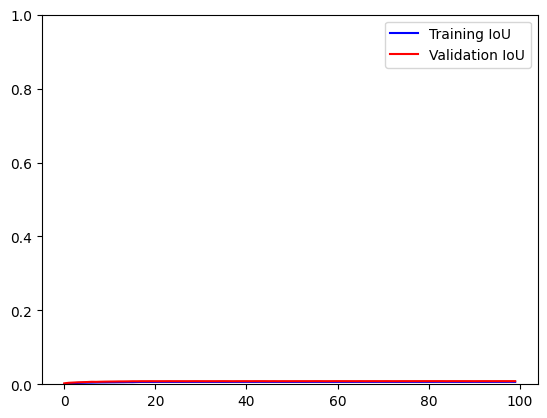

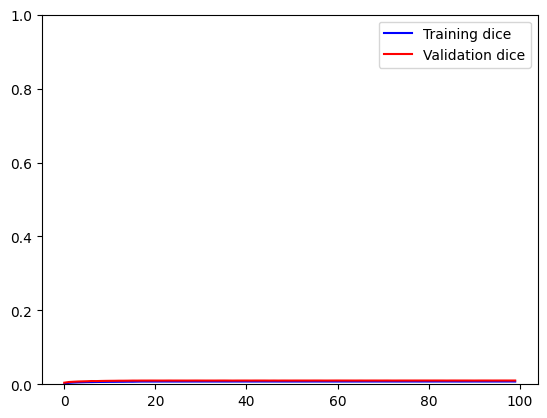

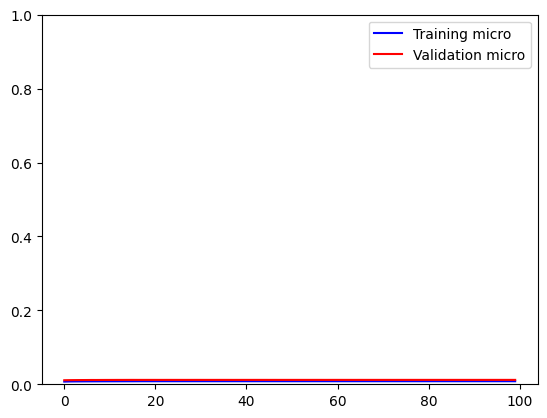

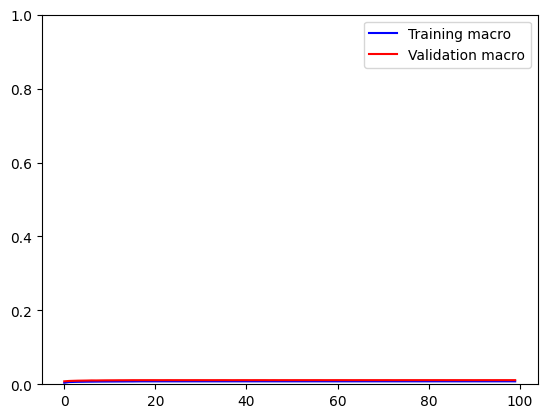

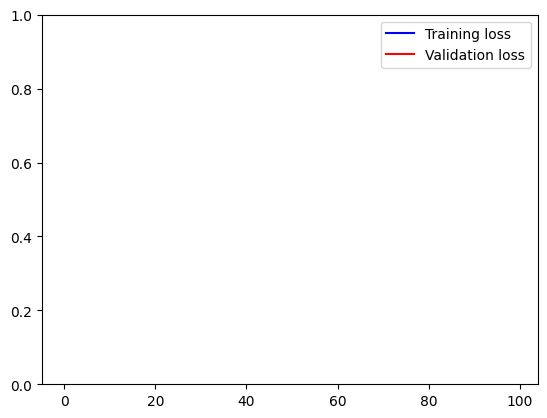

In [10]:
plot(train_iou, valid_iou)
plot(train_dice, valid_dice, label = "dice")
plot(train_micro, valid_micro, label = "micro")
plot(train_macro, valid_macro, label = "macro")
plot(train_loss, valid_loss, label = "loss")


In [11]:
torch.save(model, 'lab3/net_attempt2.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


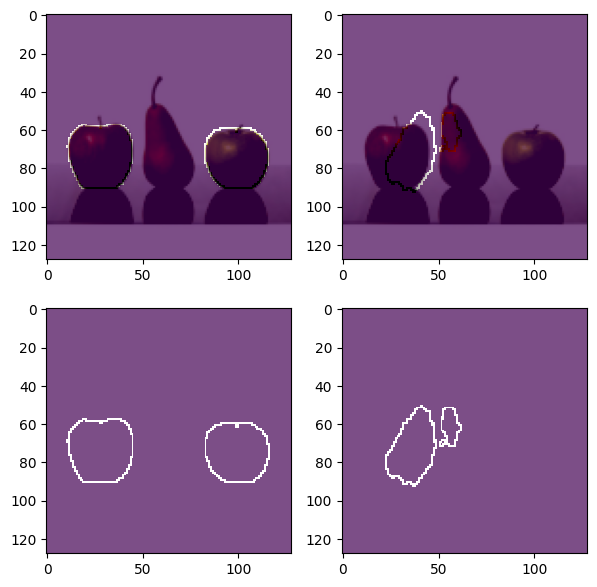

In [20]:
model = torch.load('lab3/net_attempt2.pth').to(device)

img, true_mask = valid_dataset[40]
prediction = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)

true_mask  = true_mask > .5
prediction = prediction > .5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize= (7, 7))
display_img_with_masks(ax1, img, true_mask)
display_img_with_masks(ax2, img, prediction)
display_masks(ax3, true_mask)
display_masks(ax4, prediction)

# (
#   torch.max(true_mask),
#   torch.max(prediction),
# )
# (
#   torch.count_nonzero(true_mask),
# ),(
#   torch.count_nonzero(true_mask != .0),
#   (true_mask != .0).float()[0,0,0]
# )
# prediction.shape

In [13]:
# t1 = t(
# # batch
# [
#   # masks for img 1
#   [
#     # mask for class 1
#     [[.2, .1], [.1, .3]],
#     # mask for class 2
#     [[.2, .1], [.1, .3]],
#     # mask for class 3
#     [[.2, .1], [.1, .3]],
#   ],
#   # masks for img 2
#   [
#     [[.2, .1], [.1, .5]],
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .3]],
#   ],
#   # masks for img 3
#   [
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .3]],
#   ]
# ])
# 
# 
# # values, indices = t1.max(t([0, 2]))
# # (
# #   t1,
# #   values,
# #   (values ** (-1)) #.repeat(3) #.reshape((2, 3)) * t1
# # )
# 
# BATCH_SIZE = t(t1.shape)[0]
# CLASS_NO = t(t1.shape)[1]
# DIM = t(t1.shape)[2]
# 
# vals, ix = t1.max(dim = -1)[0].max(dim = -1)[0].max(dim = -1)
# vals = vals ** -1
# t2 = vals.repeat_interleave(CLASS_NO * DIM * DIM).view((BATCH_SIZE, CLASS_NO, DIM, DIM))
# (
#   # vals.repeat(CLASS_NO).reshape((CLASS_NO, 2)).transpose(dim0 = 0, dim1 = 1)
#     # .repeat((2, 3))
#   # vals.repeat(t1.shape)
#   t(t1.shape),
#   (BATCH_SIZE, CLASS_NO, DIM, DIM),
#   # vals.repeat(t(t1.shape)[:-1].flipud().tolist()).shape
#   vals,
#   BATCH_SIZE * CLASS_NO * DIM * DIM,
#   t(t1.shape).prod(),
#   t1 * t2,
#   # vals.repeat_interleave(BATCH_SIZE * CLASS_NO * DIM * DIM).shape,
#     # vals.repeat_interleave(t(t1.shape).tolist()).shape
#   # t1 * vals
#   # t1 * vals.repeat_interleave(BATCH_SIZE * CLASS_NO * DIM * DIM).view((2, 3, 2, 2, 2)),
#   # (t2 / t1)
#   # t2 / t1
# )